<a href="https://colab.research.google.com/github/jhlee508/Colab/blob/master/classification_with_pytorch_85acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification using the CNN pyTorch

**Mounting Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Seed Setting**

In [4]:
import torch
import numpy as np
import random
import os

def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    # pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 

my_seed = 42
my_seed_everywhere(my_seed)

Importing libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import os
from torchvision import transforms
from sklearn.metrics import roc_curve, auc

Make the transformer that includes RandomRotation, ToTensor and Normalize steps. 

In [6]:
data_transforms = transforms.Compose([
            #transforms.RandomRotation(90, resample=PIL.Image.BILINEAR),
            #transforms.RandomApply((transforms.RandomHorizontalFlip(.5), 
            #                        transforms.RandomVerticalFlip(.5)), p=0.5),
            transforms.ToTensor(), 
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

Using pyTorch datasets read the train/test samples and split train set to train and validation sets. 

In [7]:
trainset = dset.ImageFolder('/content/drive/Shareddrives/SKKU-URP-GAN/all/train', 
                            transform=data_transforms)
testset = dset.ImageFolder('/content/drive/Shareddrives/SKKU-URP-GAN/all/test', 
                           transform=data_transforms)


data_size = len(trainset.samples)
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)
batch_size = 8
train_indices, val_indices = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         sampler=val_sampler)


test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

Make Flattener object

In [8]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Function for training model, computing accuracy and plotting train/val curves.

In [9]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

using device: cuda


In [34]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y) in enumerate(train_loader):
            
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print(f"Average loss: {ave_loss}, \
            Train accuracy: {train_accuracy}, \
            Val accuracy: {val_accuracy}")
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader, auc=False):
    model.eval() 
    correct_samples = 0
    total_samples = 0
    y_true, y_pred = [], []
    for (x, y) in loader:
      
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)    
        indices = torch.argmax(prediction, 1)
        fpr, tpr, _ = roc_curve(y_gpu.cpu().detach().numpy(), indices.cpu().detach().numpy())

        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
        accuracy = float(correct_samples) / total_samples
        torch.cuda.get_device_name(0)
        if auc:
            y_true.extend(y_gpu.cpu().detach().numpy())
            y_pred.extend(indices.cpu().detach().numpy())
    if auc:
        return accuracy, y_true, y_pred
    else: 
        return accuracy
    
    

    return accuracy, y_true, y_pred

def loss_accuracy_plot(loss_history, train_history, val_history):
    plt.figure(figsize=(10, 9))
    plt.subplot(311)
    # plt.ylim(bottom=0)
    plt.title("Loss")
    plt.plot(loss_history)
    plt.subplot(312)
    plt.ylim((.5, 1))
    plt.title("Train/validation accuracy")
    plt.plot(train_history, label="train")
    plt.plot(val_history, label="validation")

    plt.legend();

Creating the model, defining loss and optimizer for training procedure. 

In [35]:
device = torch.device('cuda')
# torch.set_num_threads(16)
print(torch.cuda.get_device_name(0))

nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(24),    
            Flattener(),
            nn.Linear(64*2*2, 2),
          )

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
nn_model.type(torch.cuda.FloatTensor)

nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

# optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = optim.Adam(nn_model.parameters(), lr=0.001, 
                       betas=(0.9, 0.999), eps=1e-08, 
                       weight_decay=0.0001, amsgrad=False)

Tesla P100-PCIE-16GB


Curves, accuracy

Average loss: 0.48776477575302124,             Train accuracy: 0.7639810426540284,             Val accuracy: 0.8216318785578748
Average loss: 0.3945046365261078,             Train accuracy: 0.8104265402843602,             Val accuracy: 0.8425047438330171


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Average loss: 0.3701006770133972,             Train accuracy: 0.8227488151658767,             Val accuracy: 0.8406072106261859
Average loss: 0.35012251138687134,             Train accuracy: 0.8274881516587678,             Val accuracy: 0.8633776091081594
Average loss: 0.34182173013687134,             Train accuracy: 0.8412322274881516,             Val accuracy: 0.8652751423149905


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


Average loss: 0.3297426402568817,             Train accuracy: 0.8440758293838863,             Val accuracy: 0.8690702087286527
Average loss: 0.32553809881210327,             Train accuracy: 0.8502369668246446,             Val accuracy: 0.8785578747628083
Average loss: 0.30970093607902527,             Train accuracy: 0.8549763033175355,             Val accuracy: 0.8671726755218216
Average loss: 0.30652350187301636,             Train accuracy: 0.8545023696682464,             Val accuracy: 0.857685009487666
Average loss: 0.3046751320362091,             Train accuracy: 0.8663507109004739,             Val accuracy: 0.8823529411764706
Average loss: 0.2894839644432068,             Train accuracy: 0.871563981042654,             Val accuracy: 0.8406072106261859
Average loss: 0.28569650650024414,             Train accuracy: 0.8710900473933649,             Val accuracy: 0.872865275142315
Average loss: 0.25644078850746155,             Train accuracy: 0.8834123222748815,             Val accuracy: 0

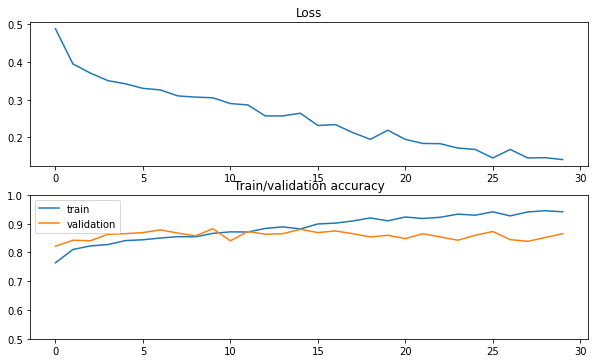

In [36]:
loss_history, train_history, val_history = train_model(nn_model, 
                                                       train_loader, 
                                                       val_loader, 
                                                       loss, 
                                                       optimizer, 30)

loss_accuracy_plot(loss_history, train_history, val_history)

print('Finished!')

test_accuracy, y_true, y_pred = compute_accuracy(nn_model, test_loader, auc=True)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_rate = auc(fpr, tpr)


print(f'Final accuracy on the test set is: {test_accuracy}; auc is: {auc_rate}')

In [37]:
test_accuracy, y_true, y_pred = compute_accuracy(nn_model, test_loader, auc=True)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_rate = auc(fpr, tpr)


print(f'Final accuracy on the test set is: {test_accuracy}; auc is: {auc_rate}')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


Final accuracy on the test set is: 0.8242424242424242; auc is: 0.8236111111111111
